# Test ResNet50 detection model with camera input

In [1]:
import numpy as np
import os, json
import cv2
import matplotlib.pyplot as plt
import io

import tensorflow as tf
from PIL import Image

import pyrealsense2 as rs

## Import model

In [2]:
path = os.getcwd()
model = tf.keras.models.load_model(path + '/model', compile="False")

In [3]:
model.summary()

Model: "RetinaNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeaturePyramid (FeaturePyra  multiple                 31585152  
 mid)                                                            
                                                                 
 sequential (Sequential)     (None, None, None, 720)   4019920   
                                                                 
 sequential_1 (Sequential)   (None, None, None, 36)    2443300   
                                                                 
Total params: 38,048,372
Trainable params: 37,995,252
Non-trainable params: 53,120
_________________________________________________________________


## Helper functions

In [4]:
def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [5]:
def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    """Resizes and pads image while preserving aspect ratio.

    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.

    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [6]:
def visualize_detections(
    image, boxes, classes, scores, ax=None, save=False, idx=0, figsize=(15, 15), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    
    fig = plt.figure()
    plt.axis("off")
    plt.imshow(image)
    if ax is None:
#         plt.figure(figsize=figsize)
        ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        if _cls == 0:
            _cls = 'tomato'
            
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
        
    if save:
        plt.savefig('detection_figures/random_set/' + str(idx) + '.png', dpi=150)

    plt.show()
    return fig

In [7]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

## Decode predictions

In [8]:
class AnchorBox:
    """Generates anchor boxes.

    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.

    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level

        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.

        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.

        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.

        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [9]:
class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.

    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=1,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=6,
        max_detections=6,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

## Create prediction model

In [10]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.8)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

# Detect objects with camera input

## Webcam as input

In [11]:
def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

Prediction: 1 detections


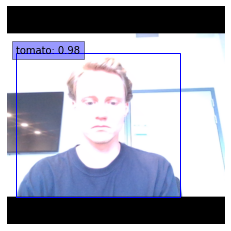

Prediction: 2 detections


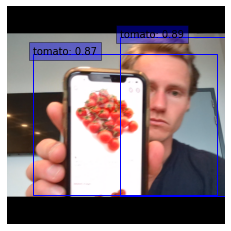

Prediction: 1 detections


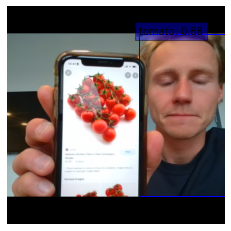

Prediction: 0 detections


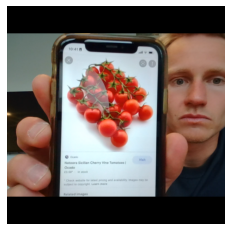

Prediction: 0 detections


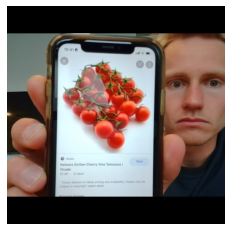

Prediction: 1 detections


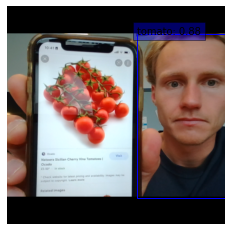

Prediction: 1 detections


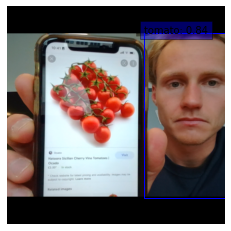

Prediction: 0 detections


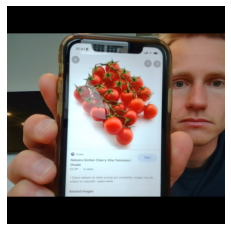

Prediction: 1 detections


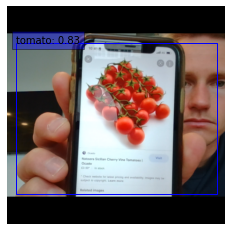

Prediction: 1 detections


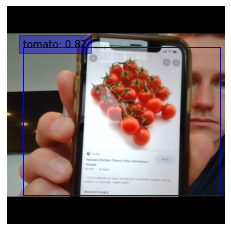

Prediction: 1 detections


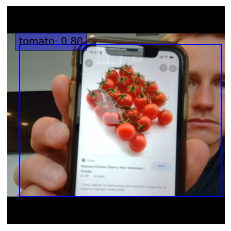

Prediction: 1 detections


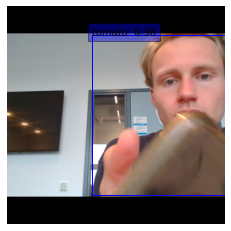

Prediction: 1 detections


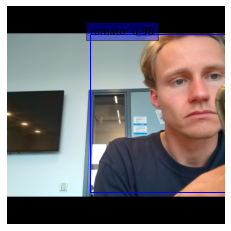

Prediction: 1 detections


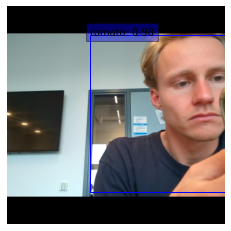

Prediction: 0 detections


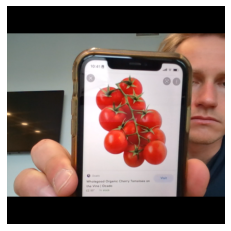

Prediction: 2 detections


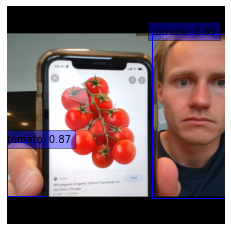

Prediction: 2 detections


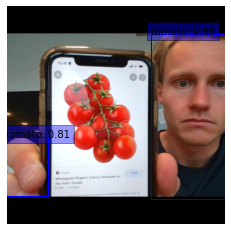

Prediction: 2 detections


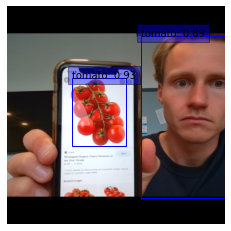

Prediction: 2 detections


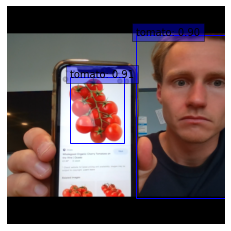

Prediction: 2 detections


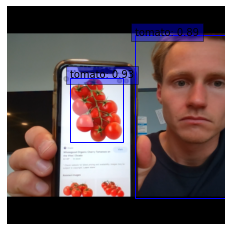

Prediction: 1 detections


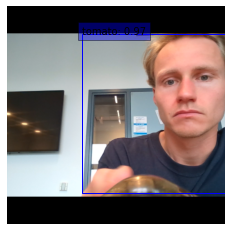

Prediction: 1 detections


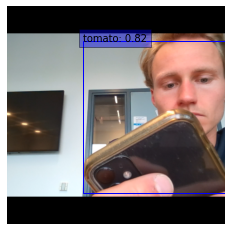

Prediction: 1 detections


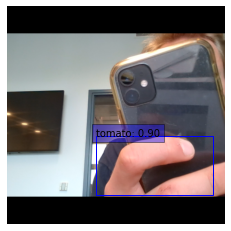

Prediction: 1 detections


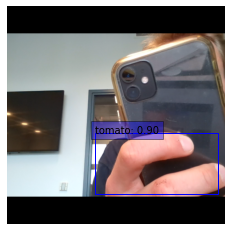

Prediction: 1 detections


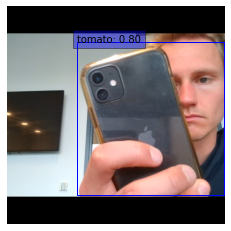

Prediction: 1 detections


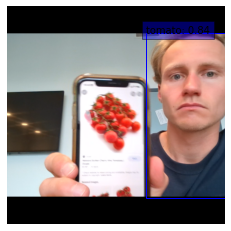

Prediction: 1 detections


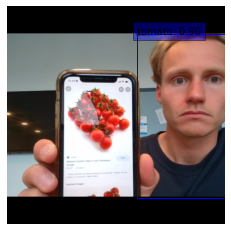

Prediction: 1 detections


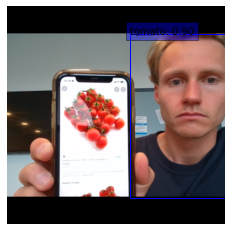

Prediction: 1 detections


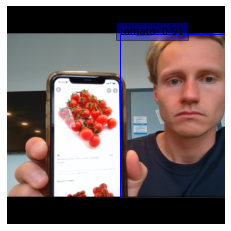

Prediction: 1 detections


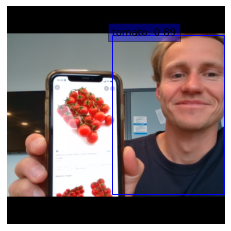

Prediction: 1 detections


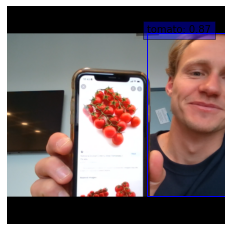

Prediction: 1 detections


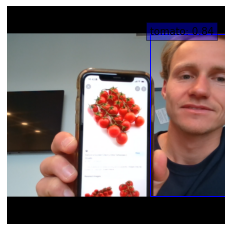

Prediction: 3 detections


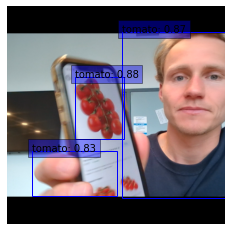

Prediction: 2 detections


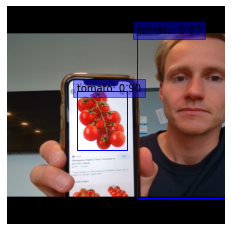

Prediction: 2 detections


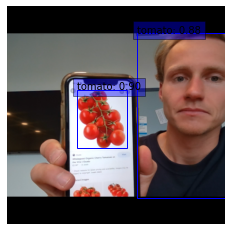

Prediction: 1 detections


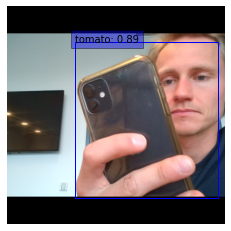

Prediction: 2 detections


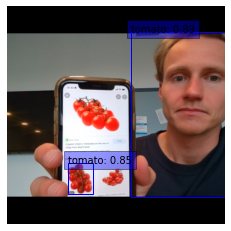

Prediction: 2 detections


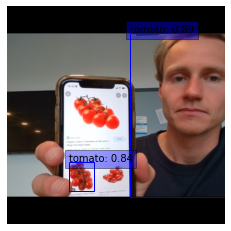

Prediction: 2 detections


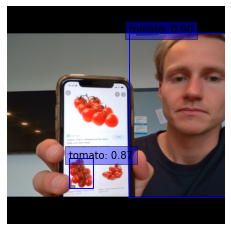

Prediction: 2 detections


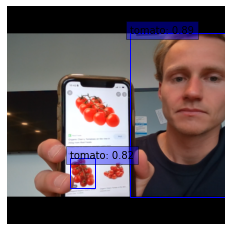

Prediction: 1 detections


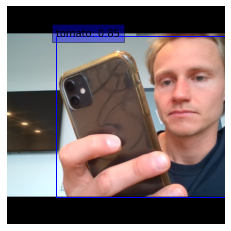

Prediction: 1 detections


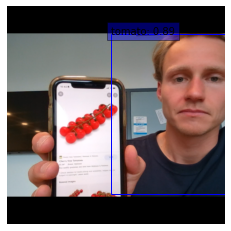

Prediction: 1 detections


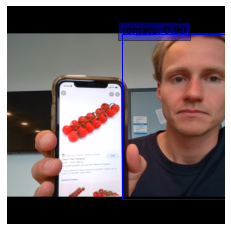

Prediction: 1 detections


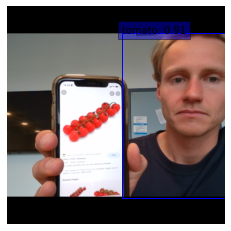

Prediction: 1 detections


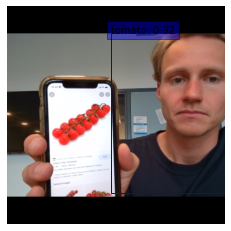

Prediction: 1 detections


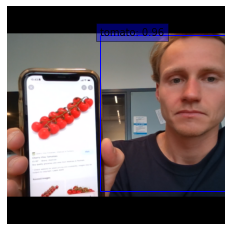

Prediction: 1 detections


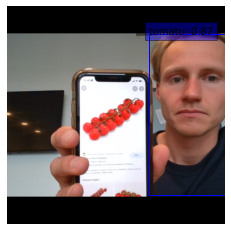

Prediction: 1 detections


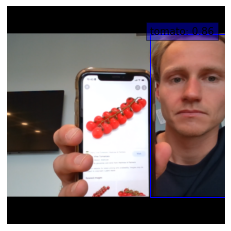

In [43]:
desired_size = 510

# define a video capture object
vid = cv2.VideoCapture(0)
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    
    # Resize image to: (desired_size, desired_size)
    im = Image.fromarray(np.uint8(frame))
    old_size = im.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    
    # create a new image and paste the resized on it
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    frame = np.array(new_im)
    
    # Prediction
    image_rgb = frame[:, :, [2, 1, 0]]
    image = tf.cast(image_rgb, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    print(f'Prediction: {num_detections} detections')
    class_names = [int(x) for x in detections.nmsed_classes[0][:num_detections]]
    bboxes_pred = detections.nmsed_boxes[0][:num_detections] / ratio
  
    # Prediction visualisation
    fig = visualize_detections(
        image,
        bboxes_pred,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    img = get_img_from_fig(fig)

    # display image with opencv or any operation you like
    cv2.imshow("plot",img)

    
    
#     # Display the resulting frame
#     cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

## RealSense as input

In [46]:
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
pipeline.start(config)

RuntimeError: No device connected

### Color frames

In [47]:
frames = pipeline.wait_for_frames()
color_frame = frames.get_color_frame()
color_image = np.asanyarray(color_frame.get_data())

RuntimeError: wait_for_frames cannot be called before start()

### Depth frames

In [ ]:
config.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)

In [ ]:
aligned_stream = rs.align(rs.stream.color) # alignment between color and depth
point_cloud = rs.pointcloud()

In [ ]:
frames = aligned_stream.process(frames)
depth_frame = frames.get_depth_frame()
points = point_cloud.calculate(depth_frame)
verts = np.asanyarray(points.get_vertices()).view(np.float32).reshape(-1, W, 3)  # xyz